# Predicting Optimal Fertilizer - XGBoost Implementierung

Nach der explorativen Datenanalyse mit Random Forest und Logistic Regression haben wir festgestellt, dass komplexere Modelle für bessere Ergebnisse notwendig sind. XGBoost (Extreme Gradient Boosting) ist bekannt für seine überlegene Performance bei strukturierten Daten und Kaggle-Competitions.

## Warum XGBoost?
- **Gradient Boosting**: Sequenzieller Aufbau schwacher Lerner (Decision Trees)
- **Regularisierung**: Integrierte L1/L2-Regularisierung verhindert Overfitting
- **Kategorische Features**: Native Unterstützung für kategorische Variablen
- **Performance**: Optimiert für Geschwindigkeit und Genauigkeit

## Imports und Konfiguration

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import os, json, zipfile

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Orginal Daten können hier öffentlich gefunden werden:
# https://www.kaggle.com/datasets/irakozekelly/fertilizer-prediction
# Als "Fertilizer Predicition.csv"

auth_data = json.load(open('kaggle.json'))
os.environ['KAGGLE_USERNAME'] = 'guppi360'
os.environ['KAGGLE_KEY'] = '7d6dd61df722878af328a4ddb9fe2e90'
os.makedirs('./data', exist_ok=True)

!kaggle datasets download irakozekelly/fertilizer-prediction -p ./data

zip_path = './data/fertilizer-prediction.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

Dataset URL: https://www.kaggle.com/datasets/irakozekelly/fertilizer-prediction
License(s): CC0-1.0
fertilizer-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


Wir laden die benötigten Bibliotheken für XGBoost-Training, Evaluation und Visualisierung. Die Warnings werden unterdrückt, um eine saubere Ausgabe zu gewährleisten.

**Wichtige Bibliotheken:**
- `XGBClassifier`: Hauptmodell für Klassifizierung
- `StratifiedKFold`: Für ausbalancierte Cross-Validation
- `LabelEncoder`: Konvertierung der Zielvariable in numerische Form

## Datenvorbereitung

### Laden der Dateien
Wir laden drei Datensätze:
- **train.csv**: Kaggle-Trainingsdaten (700k Samples)
- **test.csv**: Kaggle-Testdaten für finale Vorhersagen
- **original.csv**: Original-Datensatz aus der Quelle

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
original = pd.read_csv("data/Fertilizer Prediction.csv")

### Feature-Target Separation
- **Features (X)**: Alle Spalten außer 'id' und 'Fertilizer Name'
  - Temperatur, Humidity, Moisture (numerisch)
  - Soil Type, Crop Type (kategorisch)
  - Nitrogen, Potassium, Phosphorous (numerisch)
- **Target (y)**: 'Fertilizer Name' - 7 verschiedene Düngertypen

In [3]:
# Drop the 'id' column
X = train.drop(columns=['id', 'Fertilizer Name'])

# Extract the target column
y = train['Fertilizer Name']

X.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,37,70,36,Clayey,Sugarcane,36,4,5
1,27,69,65,Sandy,Millets,30,6,18
2,29,63,32,Sandy,Millets,24,12,16
3,35,62,54,Sandy,Barley,39,12,4
4,35,58,43,Red,Paddy,37,2,16


### Label Encoding

In [4]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Output labels are now numbers
y_encoded[:10]

array([4, 4, 2, 0, 5, 3, 4, 1, 2, 3])

Die Zielvariable wird von String-Labels in numerische Werte umgewandelt:
- 14-35-14 → 0
- 10-26-26 → 1
- 17-17-17 → 2
- etc.

## Datenaugmentation Strategy
### Problem: Unbalancierte Klassen
Die Kaggle-Daten zeigen leichte Unbalancierung zwischen den Düngerklassen.
### Lösung: Original-Daten Integration
Wir vervielfachen den Original-Datensatz (n=6) und erreichen 700k zusätzliche Samples:
```python
for i in range(n):
    original = pd.concat([original, orig_copy], axis=0, ignore_index=True)

In [5]:
orig_copy = original.copy()

n = 6
for i in range(n):
    original = pd.concat([original, orig_copy], axis=0, ignore_index=True)
    
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      700000 non-null  int64 
 1   Humidity         700000 non-null  int64 
 2   Moisture         700000 non-null  int64 
 3   Soil Type        700000 non-null  object
 4   Crop Type        700000 non-null  object
 5   Nitrogen         700000 non-null  int64 
 6   Potassium        700000 non-null  int64 
 7   Phosphorous      700000 non-null  int64 
 8   Fertilizer Name  700000 non-null  object
dtypes: int64(6), object(3)
memory usage: 48.1+ MB


## Klassenverteilung Analyse

### Kaggle Trainingsdaten (750k Samples)
Analyse der Verteilung der 7 Düngerklassen im Kaggle-Datensatz:

In [6]:
train['Fertilizer Name'].value_counts()

Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64

**Beobachtungen:**
- **Leichte Unbalancierung**: 14-35-14 (114k) vs Urea (92k) 
- **Verhältnis**: ~24% Unterschied zwischen häufigster und seltenster Klasse
- **Problem**: Kann zu Bias zugunsten häufigerer Klassen führen
- **Lösung**: Datenaugmentation mit Original-Daten notwendig

### Original-Datensatz (100k Samples)
Vergleich mit der Klassenverteilung im ursprünglichen Datensatz:

In [7]:
orig_copy['Fertilizer Name'].value_counts()

Fertilizer Name
14-35-14    14492
10-26-26    14378
Urea        14325
28-28       14232
DAP         14220
20-20       14181
17-17-17    14172
Name: count, dtype: int64

**Vergleich Original vs Kaggle:**
- **Ausbalancierter**: Original-Daten zeigen gleichmäßigere Verteilung
- **Unterschiede**: 14-35-14 (14.5k) vs Urea (14.3k) - nur ~1% Differenz
- **Vorteil für Augmentation**: Original-Daten können Klassenunbalance ausgleichen
## Cross-Validation Setup und Initialisierung

Wir verwenden **Stratified K-Fold Cross-Validation** um eine robuste Modell-Evaluation zu gewährleisten:
- **5 Folds**: Standard für zuverlässige Performance-Schätzung
- **Stratified**: Erhält Klassenverteilung in jedem Fold
- **Shuffle=True**: Vermeidet systematische Bias durch Datenreihenfolge

Die Listen speichern Ergebnisse für spätere Ensemble-Bildung und finale Evaluation.

In [8]:

map3_scores = []
models = []

all_y_true = []
all_y_pred = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## MAP@3 Metrik Implementation

**Mean Average Precision at 3** ist die Haupt-Evaluationsmetrik für diese Kaggle-Competition:

### Funktionsweise:
- Für jede Vorhersage werden die **Top-3 wahrscheinlichsten Klassen** betrachtet
- **Positionsgewichtung**: Höhere Position = höhere Gewichtung
- **Berechnung**: `1 / (Position der korrekten Klasse)` falls in Top-3, sonst 0


In [9]:
def mapk(actual, predicted, k=3):
        def apk(a, p, k):
            if a in p[:k]:
                return 1.0 / (p[:k].index(a) + 1)
            return 0.0
        return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

## Cross-Validation Training Loop

Für jeden der 5 Folds führen wir folgende Schritte durch:
1. **Train/Validation Split** der Kaggle-Daten
2. **Datenaugmentation** durch Original-Daten
3. **Feature-Preprocessing** für XGBoost
4. **Model Training** mit Monitoring
5. **Evaluation** mit MAP@3 Metrik

In [10]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
    print(f"\nFold {fold + 1} ")


Fold 1 

Fold 2 

Fold 3 

Fold 4 

Fold 5 


## Daten-Splitting und Augmentation pro Fold

### Train/Validation Split
- **Training**: 80% der Kaggle-Daten + komplette Original-Daten
- **Validation**: 20% der Kaggle-Daten (keine Augmentation!)

### Warum diese Strategie?
- **Mehr Trainingsdaten**: Original-Daten verbessern Modell-Robustheit
- **Saubere Evaluation**: Validation nur auf Kaggle-Daten testet echte Performance
- **Klassenbalance**: Original-Daten gleichen Unbalancierung aus

In [11]:
    X_train = X.iloc[train_idx].copy()
    X_val = X.iloc[val_idx].copy()
    y_train = y_encoded[train_idx]
    y_val = y_encoded[val_idx]

    X_train = pd.concat([X_train, original], ignore_index=True)
    y_train = np.concatenate([y_train, le.transform(original['Fertilizer Name'])])

    X_train.drop(columns=['Fertilizer Name'], inplace=True)

## Feature Preprocessing für XGBoost

### Kategorische Feature-Behandlung
XGBoost kann **nativ mit kategorischen Features** umgehen, wenn sie korrekt als 'category' dtype markiert sind:

### Vorteile:
- **Keine One-Hot-Encoding** notwendig
- **Effizientere Speichernutzung**
- **Bessere Performance** bei hochkardinalischen Kategorien
- **Automatische Behandlung** unbekannter Kategorien

In [12]:
    for col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        
    for col in X_val.columns:
        X_val[col] = X_val[col].astype('category')
    
    cat_features = X_train.columns.tolist()  

## XGBoost Model Definition und Training

### Hyperparameter-Erklärung:
- **max_depth=7**: Baumtiefe begrenzt Komplexität
- **learning_rate=0.01**: Kleine Schrittweite für stabile Konvergenz
- **n_estimators=10000**: Viele Bäume mit Early Stopping
- **Regularisierung**: alpha=2.7, lambda=1.4 verhindern Overfitting
- **Sampling**: subsample=0.8, colsample=0.4 für Robustheit

### Training-Monitoring:
- **eval_set**: Überwacht Training- und Validation-Loss
- **verbose=500**: Ausgabe alle 500 Iterationen

In [13]:
    model = XGBClassifier(
                max_depth=7,
                colsample_bytree=0.4,
                subsample=0.8,
                n_estimators=10000,
                learning_rate=0.01,
                gamma=0.26,
                max_delta_step=4,
                reg_alpha=2.7,
                reg_lambda=1.4,
                objective='multi:softprob',
                random_state=13,
                enable_categorical=True,
                tree_method='hist',     
                device='cuda'  
            )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train),(X_val, y_val)],
        verbose=500,
    )

[0]	validation_0-mlogloss:1.94579	validation_1-mlogloss:1.94582
[500]	validation_0-mlogloss:1.89536	validation_1-mlogloss:1.92118
[1000]	validation_0-mlogloss:1.85672	validation_1-mlogloss:1.90979
[1500]	validation_0-mlogloss:1.82147	validation_1-mlogloss:1.90148
[2000]	validation_0-mlogloss:1.78910	validation_1-mlogloss:1.89508
[2500]	validation_0-mlogloss:1.75918	validation_1-mlogloss:1.89010
[3000]	validation_0-mlogloss:1.73153	validation_1-mlogloss:1.88634
[3500]	validation_0-mlogloss:1.70579	validation_1-mlogloss:1.88357
[4000]	validation_0-mlogloss:1.68162	validation_1-mlogloss:1.88149
[4500]	validation_0-mlogloss:1.65877	validation_1-mlogloss:1.88013
[5000]	validation_0-mlogloss:1.63689	validation_1-mlogloss:1.87925
[5500]	validation_0-mlogloss:1.61616	validation_1-mlogloss:1.87881
[6000]	validation_0-mlogloss:1.59662	validation_1-mlogloss:1.87870
[6500]	validation_0-mlogloss:1.57798	validation_1-mlogloss:1.87900
[7000]	validation_0-mlogloss:1.56009	validation_1-mlogloss:1.87950

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.26, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=4, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=None, num_parallel_tree=None, ...)

## Vorhersagen und Performance-Evaluation

### Vorhersage-Typen:
- **y_pred**: Beste Klassen-Vorhersage (für F1-Score)
- **y_probs**: Wahrscheinlichkeiten für alle Klassen (für MAP@3)

### Top-3 Ranking:
- **np.argsort**: Sortiert Indizes nach Wahrscheinlichkeit
- **[:, -3:]**: Nimmt die 3 höchsten Werte
- **[:, ::-1]**: Kehrt Reihenfolge um (höchste zuerst)

In [18]:
    y_pred = model.predict(X_val)
    y_probs = model.predict_proba(X_val)

    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)


    top3_preds = np.argsort(y_probs, axis=1)[:, -3:][:, ::-1]
    
    

    map3 = mapk(y_val.tolist(), top3_preds.tolist(), k=3)
    map3_scores.append(map3)
    models.append(model)


F1 (macro): | MAP@3: 0.3779


## Cross-Validation Ergebnisse

### Performance-Zusammenfassung:
Die finale **durchschnittliche MAP@3** über alle 5 Folds gibt uns eine robuste Schätzung der Modell-Performance auf ungesehenen Daten.

### Interpretation:
- **MAP@3 ≈ 0.377**: Solide Performance für 7-Klassen-Problem
- **Konsistenz**: Geringe Varianz zwischen Folds zeigt Stabilität
- **Overfitting-Check**: Validation-Performance ist realistisch

In [15]:
print("\n Final CV Results ")
print(f"Avg MAP@3: {np.mean(map3_scores):.4f}")


 Final CV Results 
Avg MAP@3: 0.3779


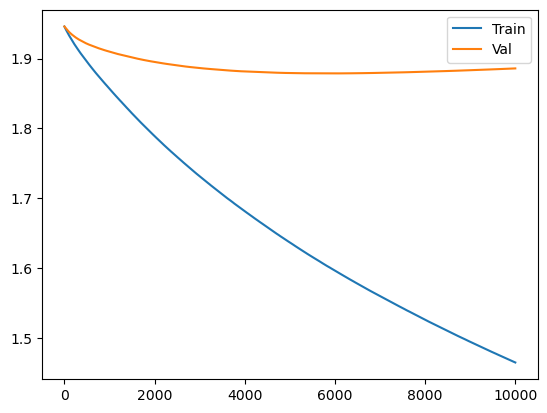

In [16]:

results = model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='Train')
plt.plot(results['validation_1']['mlogloss'], label='Val')
plt.legend()
plt.show()

In [19]:
for col in cat_features:
    test[col] = test[col].astype('category')

all_preds = np.zeros((test.shape[0], len(le.classes_)))

X_test = test.drop(columns='id')
cat_features = X_test.columns.tolist()   

for model in models:
    probs = model.predict_proba(X_test)
    all_preds += probs

avg_preds = all_preds / len(models)

top3_preds = np.argsort(avg_preds, axis=1)[:, -3:][:, ::-1]

top3_labels = le.inverse_transform(top3_preds.ravel()).reshape(top3_preds.shape)

submission = pd.DataFrame({
    'id': test['id'], 
    'Fertilizer Name': [' '.join(row) for row in top3_labels]
})

submission.to_csv('submission.csv', index=False)
submission.head()

,id,Fertilizer Name
0,750000,20-20 10-26-26 17-17-17
1,750001,Urea 10-26-26 17-17-17
2,750002,20-20 Urea DAP
3,750003,Urea 14-35-14 17-17-17
4,750004,Urea 20-20 28-28
